Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from datasets import Dataset as HFDataset
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from datetime import datetime

Environment Setup - GPU Check

In [53]:
def check_gpu():
    gpu_available = torch.cuda.is_available()
    print(f"GPU alive? {gpu_available}")
    if gpu_available:
        print(f"GPU device: {torch.cuda.get_device_name(0)} with GPU Memory - {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        print("Stuck with CPU")


In [ ]:
check_gpu()
gc.collect()
torch.cuda.empty_cache()

GPU alive? True
GPU device: NVIDIA GeForce RTX 4070 SUPER with GPU Memory - 12.9 GB


Load Pre-processed Data For Fine-Tuning

In [2]:
# Load and Prepare Training Data
print("Loading the medical Q&A Data")
train_data = pd.read_csv("train.csv")  #9061 rows (unambiguous questions only)
val_data = pd.read_csv("valid.csv")    #4872 rows (includes ambiguous questions from training)
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Sample Question: {train_data.iloc[0]['question'][:100]}...")
print(f"Sample Answer: {train_data.iloc[0]['answer'][:100]}...")

Loading the medical Q&A Data
Training samples: 9061
Validation samples: 4872
Sample Question: how to prevent glaucoma ?...
Sample Answer: at this time, we do not know how to prevent glaucoma. however, studies have shown that the early det...


Creating a Dataset Class for Q&A Fine-tuning

In [55]:
class MedQADataset:
    """
    Custom dataset class to prep for medical QA fine-tuning.
    
    Reasoning for Data Format: 
    - Instruction-following format improves model's QA capabilities
    - Special tokens help model distinguish between question and answer
    - Pre-tokenization prevents tensor length mismatches during training
    """
    def __init__(self, df, tok, max_len=1024):
        self.df = df.reset_index(drop=True)
        self.tok = tok
        self.max_len = max_len
        
    def format_prompt(self, question, answer):
        # Simple prompt template
        return f"<|user|>\n{question}\n<|assistant|>\n{answer}<|end|>"
    
    def prep_data(self):
        """Turns DF into HF dataset, tokenizes everything upfront."""
        pro_data = []
        print(f"Tokenizing {len(self.df)} samples...")
        
        for idx, row in self.df.iterrows():
            prompt = self.format_prompt(row['question'], row['answer'])
            
            # Tokenize each sample
            tokens = self.tok(
                prompt,
                truncation=True,
                max_length=self.max_len,
                padding=False,  # collator does padding later
                return_tensors=None  # Return lists, not tensors
            )
            # For causal LM, labels = input_ids
            pro_data.append({
                'input_ids': tokens['input_ids'],
                'attention_mask': tokens['attention_mask'],
                'labels': tokens['input_ids'].copy()  
            })
            
            if (idx + 1) % 1000 == 0:
                print(f"Tokenized {idx + 1}/{len(self.df)} samples")
        
        # Convert to HuggingFace Dataset
        hf_df = HFDataset.from_list(pro_data)
        
        print(f"Created dataset with {len(hf_df)} samples")
        return hf_df

Creating a Trainer Class for Q&A Fine-tuning

In [56]:
class MedicalQATrainer:
    """
    LoRA Fine-tuning for medical QA on Phi-3-mini.
    
    Architecture Reasoning:
    - LoRA Trains like 1% params, fits on my RTX 4090.
    - 4bit quant = memory saver.
    - Phi-3-mini provides good balance of capability and efficiency
    """
    
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.model_name = model_name
        self.tok = None
        self.model = None
        self.peft = None
        self.train_stats = {"train_loss": [], "eval_loss": [], "epochs": []}
        
    def setup_model_and_tokenizer(self):
        """Initializing the model with quant and tokenizer."""
        print(f"Loading model: {self.model_name}")
        
        # Tokenizer
        self.tok = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
        if self.tok.pad_token is None:  # Phi-3 quirk
            self.tok.pad_token = self.tok.eos_token
            self.tok.pad_token_id = self.tok.eos_token_id
        
        # 4-bit Quantization Configuration
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
        
        # Check if flash attention is available
        try:
            import flash_attn 
            attn = "flash_attention_2"
            print("Flash attn FTW")
        except:
            attn = "eager"  # fallback
            print("No flash, using standard attn")
        
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            q_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            torch_dtype=torch.float16,
            attn_implementation=attn
        )

        # Add this line to avoid DynamicCache issues during training
        self.model.config.use_cache = False

        # Prepare model for k-bit training
        self.model = prepare_model_for_kbit_training(self.model)

        
        print(f"Model Loaded on: {next(self.model.parameters()).device}")
        print(f"Model Dtype: {next(self.model.parameters()).dtype}")
        
    def setup_lora(self):
        """
        LoRA Setup for parameter-efficient fine-tuning.
        
        LoRA Parameters Reasoning: Rank 16 for efficiency, alpha 32 to balance adaptation strength, dropout 0.1 to reduce overfitting
        """
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=16, 
            lora_alpha=32,  
            lora_dropout=0.1,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj"],
            bias="none",
        )

        self.peft_model = get_peft_model(self.model, lora_config)
        self.peft_model.print_trainable_parameters()
        
        return lora_config
        
    def train_model(self, train_df, val_df, output_dir="./medical_qa_lora", **kwargs):
        """
        Fine-tuning the model using LoRA.
        
        The training uses a low learning rate to avoid forgetting, 
        a small batch size due to quantization limits, 
        gradient accumulation to mimic larger batches, and 
        mixed precision to cut memory use while speeding up training.
        """
        
        # Training arguments
        args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=kwargs.get('epochs', 3),
            per_device_train_batch_size=kwargs.get('batch_size', 4),
            per_device_eval_batch_size=kwargs.get('eval_batch_size', 4),
            gradient_accumulation_steps=kwargs.get('grad_accum_steps', 16),
            warmup_steps=kwargs.get('warmup_steps', 100),
            learning_rate=kwargs.get('learning_rate', 2e-4),
            fp16=True,
            logging_dir=f"{output_dir}/logs",
            logging_steps=25,
            eval_steps=100,
            save_steps=500,
            save_strategy="steps",
            eval_strategy="steps",  
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to="none",
            dataloader_pin_memory=False,
            remove_unused_columns=False,
            optim="paged_adamw_8bit",
            lr_scheduler_type="cosine",
            save_total_limit=2,
            gradient_checkpointing=True,
            gradient_checkpointing_kwargs={"use_reentrant": False}, 

        )
  
        # Custom collator that handles variable lengths
        class Cust_Collator:
            def __init__(self, tok):
                self.tok = tok
            
            def __call__(self, features):
                input_ids = [torch.tensor(f['input_ids'], dtype=torch.long) for f in features]
                att_masks = [torch.tensor(f['attention_mask'], dtype=torch.long) for f in features]
                labels = [torch.tensor(f['labels'], dtype=torch.long) for f in features]

                max_len = max(len(ids) for ids in input_ids)

                pad_ids = []
                for ids in input_ids:
                    padding_length = max_len - len(ids)
                    padded = torch.cat([ids, torch.full((padding_length,), self.tok.pad_token_id, dtype=torch.long)])
                    pad_ids.append(padded)

                pad_masks = []
                for mask in att_masks:
                    padding_length = max_len - len(mask)
                    padded = torch.cat([mask, torch.zeros(padding_length, dtype=torch.long)])
                    pad_masks.append(padded)

                pad_labels = []
                for lbls in labels:
                    padding_length = max_len - len(lbls)
                    padded = torch.cat([lbls, torch.full((padding_length,), -100, dtype=torch.long)])
                    pad_labels.append(padded)

                return {
                    'input_ids': torch.stack(pad_ids),
                    'attention_mask': torch.stack(pad_masks),
                    'labels': torch.stack(pad_labels)
                }

        
        data_collator = Cust_Collator(self.tok)
        
        # Custom trainer subclass
        trainer = Cust_Med_Trainer(
            model=self.peft_model,
            args= args,
            train_dataset=train_df,
            eval_dataset=val_df,
            tokenizer=self.tok,
            data_collator=data_collator,
        )
        
        # Start training
        print("Starting LoRA fine-tuning/n")
        print(f"Total training steps: {len(train_df) // (args.per_device_train_batch_size * args.gradient_accumulation_steps) * args.num_train_epochs}")
        
        train_result = trainer.train()
        
        # Save the final model
        trainer.save_model()
        self.tok.save_pretrained(output_dir)
        
        # Extract training statistics
        self.training_stats = self._get_stats(trainer.state.log_history)
        
        print(f"Training completed!")
        print(f"Final training loss: {train_result.training_loss:.4f}")
        
        return train_result, trainer
    

    
    def _get_stats(self, logs):
        """Pull losses from trainer logs."""
        stats = {"train_loss": [], "eval_loss": [], "learning_rate": [], "step": []}
        
        for log in logs:
            if "train_loss" in log:
                stats["train_loss"].append(log["train_loss"])
                stats["step"].append(log["step"])
            if "eval_loss" in log:
                stats["eval_loss"].append(log["eval_loss"])
            if "learning_rate" in log:
                stats["learning_rate"].append(log["learning_rate"])
        
        return stats
    
    def plot_training_curves(self):
        """Visualize training progress."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training loss
        if self.training_stats["train_loss"]:
            ax1.plot(self.training_stats["step"], self.training_stats["train_loss"])
            ax1.set_title("Training Loss")
            ax1.set_xlabel("Steps")
            ax1.set_ylabel("Loss")
            ax1.grid(True)
        
        # Evaluation loss
        if self.training_stats["eval_loss"]:
            ax2.plot(range(len(self.training_stats["eval_loss"])), self.training_stats["eval_loss"])
            ax2.set_title("Validation Loss")
            ax2.set_xlabel("Evaluation Steps")
            ax2.set_ylabel("Loss")
            ax2.grid(True)
        
        # Learning rate schedule
        if self.training_stats["learning_rate"]:
            ax3.plot(range(len(self.training_stats["learning_rate"])), self.training_stats["learning_rate"])
            ax3.set_title("Learning Rate Schedule")
            ax3.set_xlabel("Steps")
            ax3.set_ylabel("Learning Rate")
            ax3.grid(True)
        
        # Training progress summary
        ax4.text(0.1, 0.8, f"Training Summary:", fontsize=12, weight='bold')
        ax4.text(0.1, 0.6, f"Total Steps: {len(self.training_stats['step'])}", fontsize=10)
        ax4.text(0.1, 0.5, f"Final Train Loss: {self.training_stats['train_loss'][-1]:.4f}" if self.training_stats["train_loss"] else "N/A", fontsize=10)
        ax4.text(0.1, 0.4, f"Final Eval Loss: {self.training_stats['eval_loss'][-1]:.4f}" if self.training_stats["eval_loss"] else "N/A", fontsize=10)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.axis('off')
        
        plt.tight_layout()
        plt.show()

Creating a Custom Trainer Class for Domain Specifics

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer

class CustomMedTrainer(Trainer):
    """Custom trainer to track metrics and handle medical QA specifics."""
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Compute loss with additional logging."""
        labels = inputs.get("labels")
        outputs = model(**inputs)
        
        if labels is not None:
            loss = outputs.get("loss")
            if loss is None:
                logits = outputs.get("logits")
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = labels[..., 1:].contiguous()
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), 
                              shift_labels.view(-1))
        else:
            loss = outputs.get("loss")
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_results = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        # Calculating perplexity
        if f"{metric_key_prefix}_loss" in eval_results:
            perplexity = torch.exp(torch.tensor(eval_results[f"{metric_key_prefix}_loss"]))
            eval_results[f"{metric_key_prefix}_perplexity"] = perplexity.item()
            print(f"Perplexity: {perplexity.item():.4f}")
        
        return eval_results

Model Setup

In [24]:
# Initialize the trainer
trainer = MedicalQATrainer("microsoft/Phi-3-mini-4k-instruct")

# Setup model and tokenizer
trainer.setup_model_and_tokenizer()

# Setup LoRA configuration
lora_config = trainer.setup_lora()

print("Model setup completed!")

Loading model: microsoft/Phi-3-mini-4k-instruct
Flash Attention 2 not available - using standard attention


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded on: cuda:0
Model dtype: torch.float32
trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327
Model setup completed!


In [ ]:
print("Preparing training datasets...")

# Create dataset objects
train_qa_dataset = MedQADataset(train_data, trainer.tok, max_length=1024)
val_qa_dataset = MedQADataset(val_data, trainer.tok, max_length=1024)

# Prepare HuggingFace datasets
train_hf_df = train_qa_dataset.prep_data()
val_hf_df = val_qa_dataset.prep_data()

print(f"Training dataset size: {len(train_hf_df)}")
print(f"Validation dataset size: {len(val_hf_df)}")

# Check a sample
sample = train_hf_df[0]
print(f"Sample input length: {len(sample['input_ids'])}")
print(f"Sample text preview: {trainer.tok.decode(sample['input_ids'][:200])}")

Preparing training datasets...
Processing 9061 samples...
Processed 1000/9061 samples
Processed 2000/9061 samples
Processed 3000/9061 samples
Processed 4000/9061 samples
Processed 5000/9061 samples
Processed 6000/9061 samples
Processed 7000/9061 samples
Processed 8000/9061 samples
Processed 9000/9061 samples
Created dataset with 9061 samples
Processing 4872 samples...
Processed 1000/4872 samples
Processed 2000/4872 samples
Processed 3000/4872 samples
Processed 4000/4872 samples
Created dataset with 4872 samples
Training dataset size: 9061
Validation dataset size: 4872
Sample input length: 117
Sample text preview: <|user|> how to prevent glaucoma ?
<|assistant|> at this time, we do not know how to prevent glaucoma. however, studies have shown that the early detection and treatment of glaucoma, before it causes major vision loss, is the best way to control the disease. so, if you fall into one of the higher risk groups for the disease, make sure to have a comprehensive dilated eye exam a

In [26]:
# Training hyperparameters
training_config = {
    'epochs': 3,
    'batch_size': 4,  # Small batch size for memory efficiency
    'eval_batch_size': 4,
    'grad_accum_steps': 16 ,
    'learning_rate': 2e-4,
    'warmup_steps': 100,
}

print("Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

print(f"Effective batch size: {training_config['batch_size'] * training_config['grad_accum_steps']}")

# Start training
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"./medical_qa_lora_{timestamp}"

train_result, trained_model = trainer.train_model(
    train_hf_df,
    val_hf_df,
    output_dir=output_dir,
    **training_config
)

print(f"Model saved to: {output_dir}")

Training Configuration:
  epochs: 3
  batch_size: 4
  eval_batch_size: 4
  grad_accum_steps: 16
  learning_rate: 0.0002
  warmup_steps: 100
Effective batch size: 64
Starting LoRA fine-tuning...
Total training steps: 423


C:\Users\srava\AppData\Local\Temp\ipykernel_9684\4110978744.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomMedicalTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomMedicalTrainer(


Step,Training Loss,Validation Loss
100,0.962300,1.080490
200,0.908400,1.036799
300,0.860600,1.021132
400,0.849500,1.016530


Perplexity: 2.9461
Perplexity: 2.8202
Perplexity: 2.7763
Perplexity: 2.7636
Training completed!
Final training loss: 0.9671
Model saved to: ./medical_qa_lora_20250917_204739


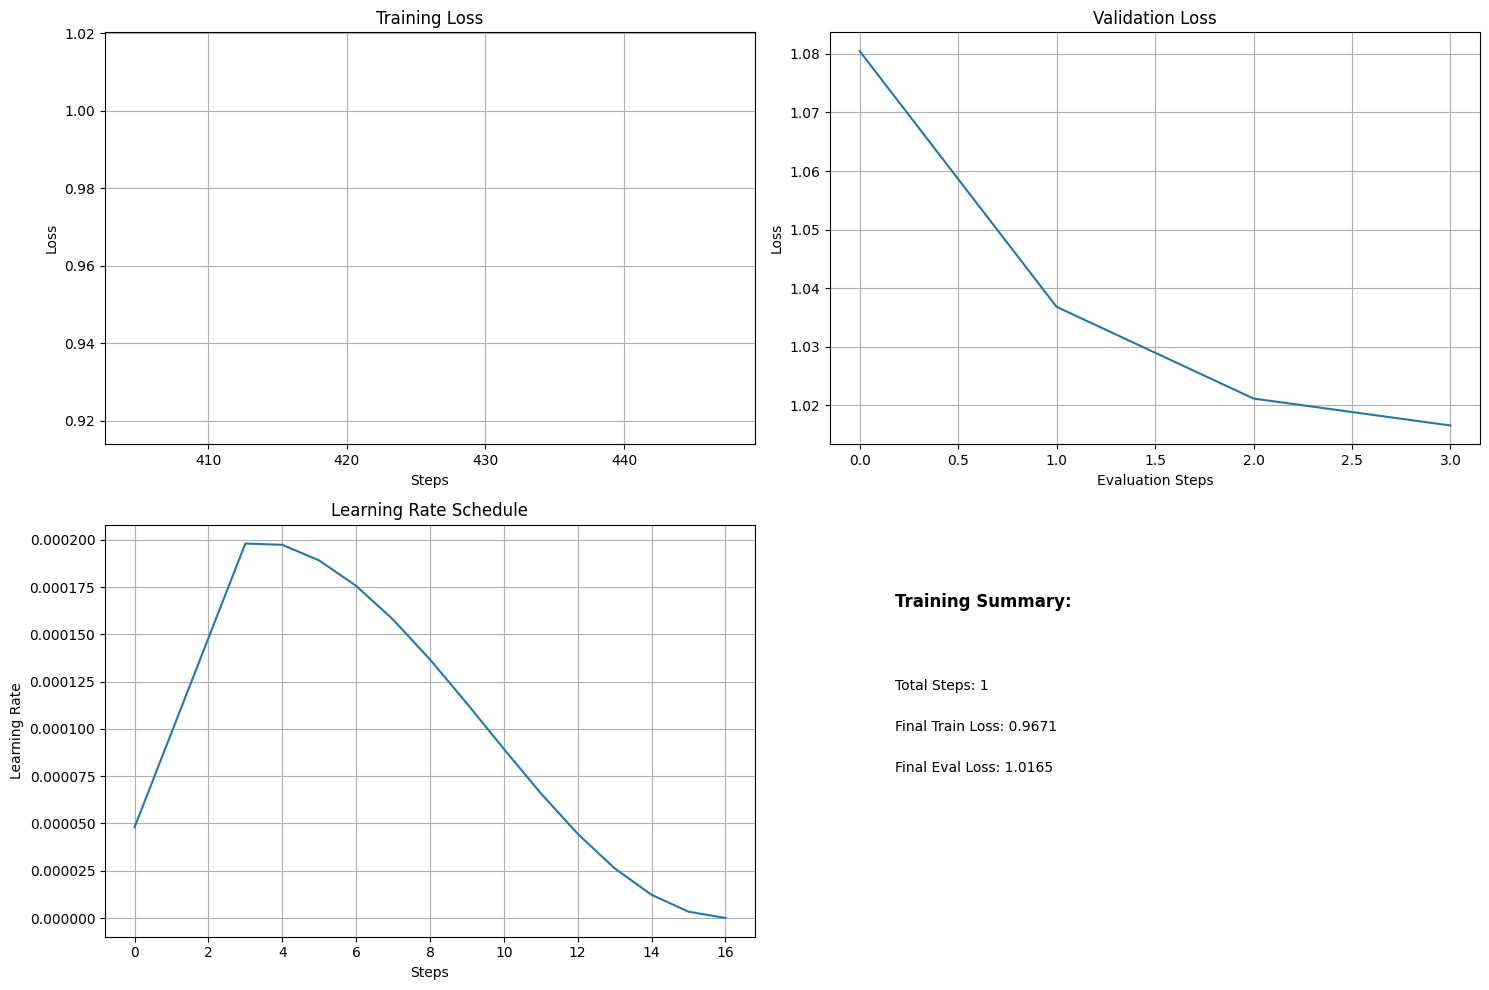


Training Summary:
Final Training Loss: 0.9671
Training Time: 96883.22 seconds
Samples per second: 0.28
Training statistics saved to: ./medical_qa_lora_20250917_204739/training_statistics.json


In [ ]:
trainer.plot_training_curves()

# Print final statistics
print("\nTraining Summary:")
print(f"Final Training Loss: {train_result.training_loss:.4f}")
print(f"Training Time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

# Save training statistics
stats_file = f"{output_dir}/training_statistics.json"
with open(stats_file, 'w') as f:
    json.dump(trainer.training_stats, f, indent=2)
print(f"Training statistics saved to: {stats_file}")

Answer Generation Check

In [ ]:
# Quick test of the fine-tuned model

def check_answer(q, max_tokens=200):
    # Format prompt
    prompt = f"<|user|>\n{q}\n<|assistant|>\n"
    
    # Tokenize - keep it simple
    inputs = trainer.tok(
        prompt, 
        return_tensors="pt", 
        truncation=True, 
        max_length=1024
    ).to(trainer.peft_model.device)  # match device with model
    
    # Generate - tweaked params for decent output
    with torch.no_grad():
        out = trainer.peft_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,  # bit of randomness
            temperature=0.7,  # not too wild
            top_p=0.9,  # keep it focused
            pad_token_id= trainer.tok.eos_token_id,
            eos_token_id= trainer.tok.eos_token_id,
            use_cache=False 
        )
    
    # Decode and clean up
    full_text = trainer.tok.decode(out[0], skip_special_tokens=True)
    
    # Clean up: remove question and any prompt bits
    ans = full_text
    # Strip out the question if it’s there
    if q in ans:
        ans = ans.split(q, 1)[1] if len(ans.split(q, 1)) > 1 else ans
    # Extra cleanup for any lingering prompt-like text
    for to_remove in [prompt, q.strip("'"), q.strip()]:
        ans = ans.replace(to_remove, "").strip()
    
    return ans.strip()

# Try it on some med Qs
qs = [
    "How to diagnose high blood pressure ?'",
    "Is klippel-feil syndrome inherited ?",
    "what is the outlook for barth syndrome?",
    "How is type 2 diabetes typically managed?"
]

print("Testing the model for a test run:")
print("="*50)

for i, q in enumerate(qs, 1):
        ans = check_answer(q)
        print(f"[{i}] {q}")
        print(f"Bot: {ans}")
        print("-" * 30)

Testing the model for a test run:
[1] How to diagnose high blood pressure ?'
Bot: your doctor will diagnose high blood pressure by measuring your blood pressure. high blood pressure is diagnosed when the blood pressure is 140/90 mm hg or higher. the top number is the systolic blood pressure, which measures pressure in the arteries when the heart beats. the bottom number is the diastolic blood pressure, which measures pressure in the arteries between heartbeats. the higher the blood pressure, the harder your heart has to work to pump blood through your body. if you have high blood pressure, your doctor may want you to have your blood pressure measured several times. to get an accurate reading, you should: relax for at least 5 minutes before the test. avoid smoking for at least 30 minutes before the test. avoid caffeine for at least 30 minutes before the test. avoid exercise for at least 30 minutes before the test. sit with your back supported and
------------------------------
[2] Is kl

Sample Validation Data Evaluations

In [ ]:
from tqdm import tqdm
import evaluate

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

max_samps = 100
n = min(max_samps, len(val_data))
val_sub = val_data.sample(n=n, random_state=42).copy()

preds, refs = [], []

print(f"Running eval on {len(val_sub)} samples...")
for _, samp in tqdm(val_sub.iterrows(), total=len(val_sub), desc="Evaluation Metrics"):
    if "input_ids" in samp:
        # Decode full prompt from token ids
        prompt = trainer.tok.decode(samp["input_ids"], skip_special_tokens=False)
    else:
        # Build prompt from columns if input_ids aren’t present
        qtxt = str(samp["question"]).strip()
        atxt = str(samp["answer"]).strip()
        prompt = f"<|user|>\n{qtxt}\n<|assistant|>\n{atxt}<|end|>"

    # Parse question
    parts = prompt.split("<|assistant|>")
    user_block = parts[0] if parts else ""
    q = user_block.replace("<|user|>\n", "").strip()

    # Parse reference answer
    ans_block = parts[1] if len(parts) > 1 else ""
    ref = ans_block.split("<|end|>")[0].strip()

    # Get model prediction
    pred = check_answer(q, max_tokens=200)

    preds.append(str(pred).strip())
    refs.append(str(ref).strip())

# Compute metrics
print("\nCalculating scores...")
rouge_res = rouge.compute(predictions=preds, references=refs)
# BLEU expects list[list[str]] for references
bleu_res = bleu.compute(predictions=preds, references=[[r] for r in refs])

print("\nScores:")
print(f"ROUGE-1: {rouge_res['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_res['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_res['rougeL']:.4f}")
print(f"BLEU:    {bleu_res['bleu']:.4f}")

Running eval on 100 samples...


Evaluation Metrics: 100%|██████████| 100/100 [35:52<00:00, 21.53s/it]



Calculating scores...

Scores:
ROUGE-1: 0.3678
ROUGE-2: 0.1755
ROUGE-L: 0.2597
BLEU:    0.0724
